https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt

print(tf.version.VERSION)
import pickle

import os

2.12.0-rc0


In [2]:
NUM_CATEGORY = 8
BATCH_SIZE = 16
EPOCHS = 20
SAMPLE_SIZE = 10000

VOCAB_SIZE = 2000 # Maximum vocab size.
MAX_LEN = 400  # Sequence length to pad the outputs to.

In [3]:
from keras.callbacks import Callback
class History(Callback):
    """
    Callback that records events into a `History` object.

    This callback is automatically applied to
    every Keras model. The `History` object
    gets returned by the `fit` method of models.
    """

    def on_train_begin(self, logs=None):
        if not hasattr(self, 'epoch'):
            self.epoch = []
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)


class ModelCheckpoint(Callback):

    def __init__(self, freq, directory):
        super().__init__()
        self.freq = freq
        self.directory = directory

    def on_epoch_begin(self, epoch, logs=None):
        if self.freq > 0 and epoch % self.freq == 0:
            self.model.save_pretrained(os.Path(self.directory, str(epoch)))

    def on_train_end(self, logs=None):
        self.model.save_pretrained(self.directory)

In [6]:
# df = pd.read_csv("dataset_final_stem_only_eng.csv")
df = pd.read_csv("./3_Preprocessing/dataset_lemmatized.csv")

# df['type'].unique()
# len(df['type'].unique())
print(df.shape)
df.head()

(39567, 7)


,index,name,link,lang_eng,valid_dir,value,type
0,0,Australian National University,http://www.anu.edu.au/,1,1,anu newsroom anu study anu research innovation...,Education
1,1,Monash University,http://www.monash.edu/,1,1,monash university one top university australia...,Education
2,2,University of Queensland,http://www.uq.edu.au/,1,1,university queensland university queensland ch...,Education
3,3,Macquarie University,http://mq.edu.au/,1,1,macquarie university tertiary education curren...,Education
4,4,UNSW Sydney,https://www.unsw.edu.au/,1,1,unsw sydney one best university australia unsw...,Education


In [7]:
df["type"].unique()

array(['Education', 'Nonprofit', 'Facility', 'Government', 'Company',
       'Healthcare', 'Other', 'Archive'], dtype=object)

In [8]:
# sample_df = df[(df["type"] == "Company") | (df["type"] == "Education")].sample(n=SAMPLE_SIZE)
# sample_df = df[(df["type"] == "Company") | (df["type"] == "Education")]
sample_df = df.sample(SAMPLE_SIZE)
# sample_df = df
sample_df.head(5)

,index,name,link,lang_eng,valid_dir,value,type
1375,2566,St. Catherine University,http://www.stkate.edu/,1,1,catherine university paul minnesota coronaviru...,Education
14965,38034,John Paul the Great Catholic University,https://jpcatholic.edu/,1,1,john paul great catholic university jpcatholic...,Education
17324,43956,Logikos (United States),http://www.logikos.com/,1,1,logikos custom software service fort wayne log...,Company
438,977,Institute of Chemistry,http://www.chem.sk/,1,1,institute chemistry nmr lab chemicky ustav nmr...,Facility
31463,81683,Concern Granit-Electron (Russia),https://www.granit-electron.ru/en/,1,1,jsc concern granit electron site map site map ...,Company


In [9]:
print(sample_df['type'].unique())
print(sample_df.shape)

['Education' 'Company' 'Facility' 'Nonprofit' 'Healthcare' 'Archive'
 'Government' 'Other']
(10000, 7)


# Tensorflow Keras CountVectorizer layer (LSTM)

In [10]:
from sklearn.model_selection import train_test_split

X = sample_df["value"]
y = sample_df["type"]
y = to_categorical(np.asarray(y.factorize()[0]), num_classes=NUM_CATEGORY)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [11]:
# Create the layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)
vectorize_layer.adapt(np.array(X_train).flatten())

In [12]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'public', 'university', 'health', 'research',
       'foundation', 'service', 'news', 'center', 'college', 'care',
       'transitional', 'institute', 'technology', 'information', 'new',
       'product', 'science', 'community'], dtype='<U32')

In [13]:
# LSTM model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorize_layer.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation="softmax")
    ])

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  # metrics=[tf.keras.metrics.CategoricalCrossentropy()])
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return model


# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1,), dtype=tf.string),
#     vectorize_layer,
#     tf.keras.layers.Embedding(
#         input_dim=len(vectorize_layer.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True
#     ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     # tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(8, activation="softmax")
# ])
# model.summary()

In [14]:

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               # metrics=[tf.keras.metrics.CategoricalCrossentropy()])
#               metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [16]:
model.load_weights("./model_checkpoints/model.20-0.8825-0.7258")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 400, 64)           128000    
                                                                 
 bidirectional (Bidirectiona  (None, 400, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

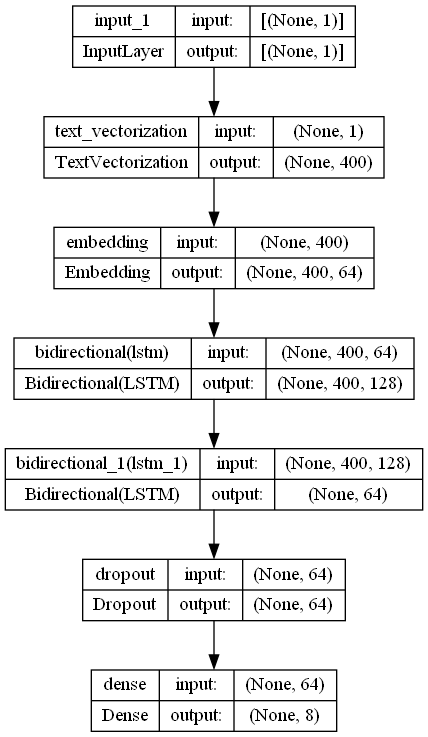

In [15]:
model = create_model()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# test_loss, test_acc = model.evaluate(X_test, y_test)
#
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_acc)

In [47]:
# model = keras.models.load_model("./model_checkpoints/model.02-1.5510-0.4848/model.02-1.5510-0.4848.ckpt")
#
# test_loss, test_acc = model.evaluate(X_test, y_test)
#
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_acc)

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# checkpoint = ModelCheckpoint("best_model", monitor="val_categorical_accuracy", verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

callbacks_list = [
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./model_checkpoints/model.{epoch:02d}-{val_loss:.4f}-{val_categorical_accuracy:.4f}/model.{epoch:02d}-{val_loss:.4f}-{val_categorical_accuracy:.4f}.ckpt',
    #     save_freq='epoch', verbose=1, monitor='val_loss',
    #     save_weights_only=True, save_best_only=False,
    # ),
    ModelCheckpoint(
        filepath='./model_checkpoints/model.{epoch:02d}-{val_loss:.4f}-{val_categorical_accuracy:.4f}',
        freq=1,
        directory="./model_checkpoints/model.{epoch:02d}-{val_loss:.4f}-{val_categorical_accuracy:.4f}'"
    )
    # ModelCheckpoint("best_model", monitor="val_categorical_accuracy", verbose=1, save_best_only=True, mode='max')
]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, validation_steps=30, callbacks=[callbacks_list], verbose=1, initial_epoch=0)

Epoch 11/20


C:\Users\Martin\DataspellProjects\bakalarka\venv\Lib\site-packages\keras\backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 11/235 [>.............................] - ETA: 1:07 - loss: 2.0716 - categorical_accuracy: 0.2557

KeyboardInterrupt: 

# Zatial najlepsie:
    75.23 (rozsireny dataset - keras TextVectorization layer, LSTM)
    73.90 (rozsireny dataset - keras TextVectorization layer, LSTM)
    71.28 (rozsireny dataset - keras TextVectorization layer, LSTM)
    67.52 (rozsireny dataset - sklearn TextVectorization, Conv1D)

In [55]:
# history10 = history

In [49]:
# Saving model
# pickle.dump(model, open("model", 'wb'))

In [50]:
# Load model
# model = pickle.load(open("model", 'rb'))

In [23]:
print(model.history.history)

{}


In [21]:
# h = history.history

plt.plot(h["loss"], label="loss")
plt.plot(h["val_loss"], label="val_loss")
# plt.plot(h["val_loss"], label="val_loss")
plt.title("Loss", fontsize=20)
plt.legend()
plt.show()

KeyError: 'loss'

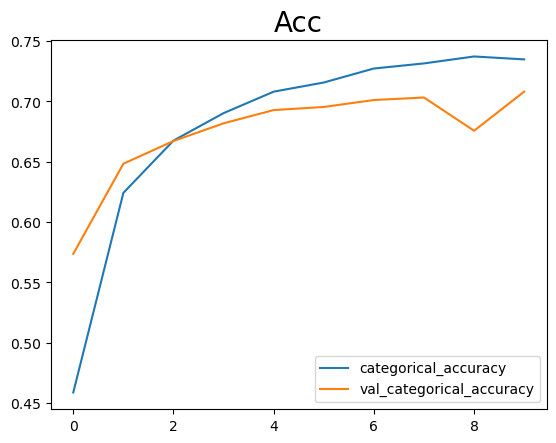

In [52]:
plt.plot(h["categorical_accuracy"], label="categorical_accuracy")
plt.plot(h["val_categorical_accuracy"], label="val_categorical_accuracy")
# plt.plot(h["val_loss"], label="val_loss")
plt.title("Acc", fontsize=20)
plt.legend()
plt.show()

In [53]:
# test_loss, test_acc = model.evaluate(gen_val)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

316/316 [==============================] - 232s 733ms/step - loss: 0.9170 - categorical_accuracy: 0.7081
Test Loss: 0.9169555902481079
Test Accuracy: 0.7081145644187927


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = df.columns
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(11,11))
disp.plot(ax=ax, cmap="Greens")
plt.title("Confusion matrix for individual characters", fontsize=20)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

316/316 [==============================] - 243s 748ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
# Doterajsie vysledky

# Cely DS:
#   2 kategorie ("Company" a "Education"):
#       15 epoch:
#           Train Acc: 0.9663   Train Loss: 0.0858
#           Test Acc = 0.9286   Test Loss: 0.2270
#       20 epoch:
#           Train Acc: 0.9671   Train Loss: 0.0783
#           Test Acc = 0.9270   Test Loss: 0.2536
#       50 epoch:
#           Train Acc: 0.9738   Train Loss: 0.0609
#           Test Acc = 0.9167   Test Loss: 0.4088
#
#   8 kategorii:
#       70 epoch:
#           Train Acc: 0.82     Train Loss: ?
#           Test Acc: 0.611     Test Loss: ?
#       100 epoch:
#           Train Acc: 0.8647   Train Loss: 0.3846
#           Test Acc: 0.606     Test Loss: 3.0083
#       130 epoch:
#           Train Acc: 0.8856   Train Loss: 0.3287
#           Test Acc: 0.6014    Test Loss: 3.6702
#       150 epoch:
#           Train Acc: 0.8898   Train Loss: 0.3170
#           Test Acc: 0.5954    Test Loss: 3.7761